<a href="https://colab.research.google.com/github/MuhammedOZCELIK/GenetikAlgoritmaYapayZekaProje1Senaryo3/blob/main/yapayZekaProje1Seneryo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Muhammed Emin ÖZÇELİK
2212721063

=== EN İYİ ÇÖZÜM ===
Ortalama hız (avg_speed) : 60.0000 km/h
Yük kapasitesi (payload) : 10.0000 ton
v * p                   : 600.0000 (<= 700.0)
Amaç değeri (y)         : -90.000000


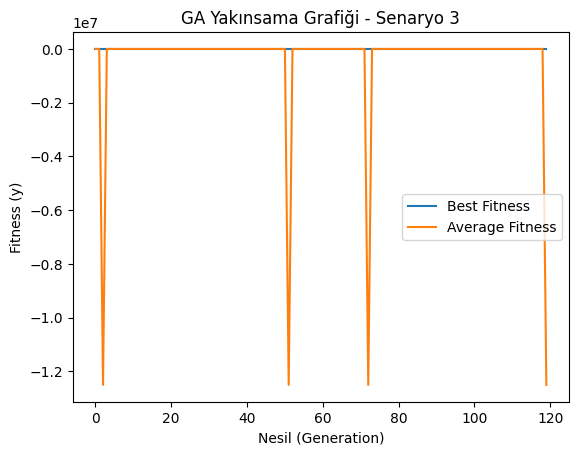

In [ ]:
import random
import math
import matplotlib.pyplot as plt

# ayarlar
V_MIN, V_MAX = 40.0, 100.0
P_MIN, P_MAX = 2.0, 10.0       #hız sınırı ve yük sınırı


MIN_SPEED = 60.0
POWER_LIMIT = 700.0            #kısıtlar (motor gücü ve minimum hız)

# GA parametreleri
POP_SIZE = 80    #Popülasyondaki birey sayısı
N_GEN = 120        #Nesil sayısı
TOURNAMENT_K = 3        #Turnuva seçiminde her seçim için kaç aday karşılaştırılacak
CROSSOVER_RATE = 0.85    #Çaprazlama olasılığı (İki ebeveynden çocuk üretme işlemi çoğu zaman yapılsın diye yüksek)
MUTATION_RATE = 0.25     #Mutasyon olasılığı

# Gaussian mutasyonda şiddet (Hız daha geniş aralıkta olduğu için sigma daha büyük, yük daha dar aralıkta olduğu için sigma daha küçük)
SIGMA_V = 6.0
SIGMA_P = 0.8

random.seed(42)



# Amaç Fonksiyonu

def objective(avg_speed, payload_ton):
    # y = -2v - 3p + 0.1 v p (Amaç fonksiyonunu hesaplayan fonksiyon)
    return (-2.0 * avg_speed) - (3.0 * payload_ton) + (0.1 * avg_speed * payload_ton)



# Kısıt Kontrol ve Repair

def clamp(val, lo, hi):   #val değerini lo ve hi arasında tutar
    return max(lo, min(hi, val))    # val alt sınırın altındaysa lo üst sınırın üstündeyse hi

def is_feasible(avg_speed, payload_ton):    # şartları kontrol ediyor yani hızı ve payloadı
    if avg_speed < MIN_SPEED:  # v >= 60 şartı
        return False
    if not (V_MIN <= avg_speed <= V_MAX):    # hız 40 la 100 arası mı kontrolü
        return False
    if not (P_MIN <= payload_ton <= P_MAX): #yükün 2 ve 10 aralığında mı kontrolü
        return False
    if avg_speed * payload_ton > POWER_LIMIT:  #motor gücünün kontrolü (700 ve 700den büyükse sayılmaz)
        return False
    return True   # her şey sağlanıyorsa uygundur (feasible)

def repair(avg_speed, payload_ton):       #uygunsuzsa repairler
    # 1) değişkenleri kendi sınırlarına çekeriz
    avg_speed = clamp(avg_speed, V_MIN, V_MAX)
    payload_ton = clamp(payload_ton, P_MIN, P_MAX)

    # 2) minimum hızın altına düşmemesi için ayarlıyoruz
    avg_speed = max(avg_speed, MIN_SPEED)

    # 3) motor gücü limiti kontrol
    if avg_speed * payload_ton > POWER_LIMIT:
        # payload'ı limitin altına çek
        payload_ton = min(payload_ton, POWER_LIMIT / avg_speed)
        payload_ton = clamp(payload_ton, P_MIN, P_MAX)
                                                                   # Eğer aşıyorsa önce payloadı azaltıyoruz yetmezse hızı azaltıyoruz
    if avg_speed * payload_ton > POWER_LIMIT:
        # hala aşıyorsa hızı düşür
        avg_speed = min(avg_speed, POWER_LIMIT / payload_ton)
        avg_speed = clamp(avg_speed, MIN_SPEED, V_MAX)

    return avg_speed, payload_ton



# Birey, Başlangıç Popülasyonu

def make_individual():
   #kısıtları sağlayan birey üretir
    for _ in range(2000): #2000 kere deniycek uygun bireyi
        v = random.uniform(V_MIN, V_MAX)
        p = random.uniform(P_MIN, P_MAX)
        v, p = repair(v, p)
        if is_feasible(v, p):
            return [v, p]
            #rastgele hız yük seçimi ve kısıtlama sağlasın diye düzeltme
    # Çok nadir 2000den uygun birey çıkmazsa garanti başlangıç çözümü - fallback
    v = 70.0
    p = min(P_MAX, POWER_LIMIT / v)
    return [v, p]

def make_population(n):
    return [make_individual() for _ in range(n)]
#n tane birey üretip popülasyon listesi döndürüyor


# Seçim (Tournament)

def tournament_select(pop, fitnesses, k=TOURNAMENT_K):  #turnuvayla ebeveyn seçilir
    best_idx = None   #şimdilik en iyi aday yok
    for _ in range(k):
        i = random.randrange(len(pop))
        if (best_idx is None) or (fitnesses[i] > fitnesses[best_idx]):
            best_idx = i
    return pop[best_idx][:]  #[:] orjinal bireyi bozmamak için
#rastgele aday seçer bi öncekinden iyiyse en iyi aday artık o olur



# Çaprazlama (Arithmetic/Blend)

def crossover(parent1, parent2):
    #iki ebeveynden iki çocuk üretir
    alpha = random.random()   #0-1 arasında karışım katsayısı

    c1_v = alpha * parent1[0] + (1 - alpha) * parent2[0]   #çocuk1 in genleri ebeveynlerin lineer karışımı
    c1_p = alpha * parent1[1] + (1 - alpha) * parent2[1]

    c2_v = alpha * parent2[0] + (1 - alpha) * parent1[0] #çocuk2 karışımı ters yaparak çeşitlilik sağlanor
    c2_p = alpha * parent2[1] + (1 - alpha) * parent1[1]

    c1_v, c1_p = repair(c1_v, c1_p)
    c2_v, c2_p = repair(c2_v, c2_p)
    #çocuklar kısıtın dışına çıkmış olabilir repair
    return [c1_v, c1_p], [c2_v, c2_p]



# Mutasyon (Gaussian)

def mutate(ind):
    v, p = ind   #bireyi v p genlerine ayırdık

    if random.random() < 0.5:
        v += random.gauss(0, SIGMA_V)  #%50 ihtimalle hızı mutasyona ugrat
    else:
        p += random.gauss(0, SIGMA_P) #%50 ihtimalle yükü mutasyona uğrat


    v, p = repair(v, p) #repair
    return [v, p]



# 8) GA Döngüsü

def evaluate_population(pop):
    fits = []   #fitness değerini tutacak liste
    for v, p in pop:
        # feasible değilse ağır ceza (normalde repair ile feasible kalmalı)
        if not is_feasible(v, p):
            fits.append(-1e9)
        else:
            fits.append(objective(v, p)) #uygunsa amaç fonksiyonunu fitness olarak ekle
    return fits

population = make_population(POP_SIZE)  #ilk popülasyonu oluştur
best_history = []
avg_history = []    #en iyi ve ort fitnessı kaydet

for gen in range(N_GEN):
    fitnesses = evaluate_population(population) #her nesil çalışır ve mevcut popun fitnessını hesaplar

    best_fit = max(fitnesses)
    avg_fit = sum(fitnesses) / len(fitnesses) #bu nesildeki en iyi ve ort fitness

    best_history.append(best_fit)   #grafikte kullancaz kaydediyoruz
    avg_history.append(avg_fit)

    # Elitizm: en iyi 2 bireyi direkt taşı
    elite_count = 2
    elite_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)[:elite_count]  #fitnessa göre sıralayıp en iyi 2yi al
    new_pop = [population[i][:] for i in elite_indices]  #yeni popülasyona elitleri kopyala

    # Yeni popülasyon üret
    while len(new_pop) < POP_SIZE: #dolana kadar çocuk üret
        p1 = tournament_select(population, fitnesses)
        p2 = tournament_select(population, fitnesses)

        if random.random() < CROSSOVER_RATE:
            c1, c2 = crossover(p1, p2)  #çaprazlama yap yapmazsa ebeveynleri direk geçir
        else:
            c1, c2 = p1, p2

        if random.random() < MUTATION_RATE:
            c1 = mutate(c1)
        if random.random() < MUTATION_RATE:   #her çocuk belirli olasılıkla mutasyon olur
            c2 = mutate(c2)

        new_pop.append(c1)
        if len(new_pop) < POP_SIZE:
            new_pop.append(c2)

    population = new_pop #populasyonu yenisiyle değiş

# Sonuç
final_fitnesses = evaluate_population(population)  #son popun fitnesslarını hesaplar
best_idx = max(range(len(population)), key=lambda i: final_fitnesses[i])  #fitness en yüksek bireyin indexini bul
best_v, best_p = population[best_idx]  #en iyi bireyin genlerini ve fitnessını al
best_y = final_fitnesses[best_idx]

print("=== EN İYİ ÇÖZÜM ===")
print(f"Ortalama hız (avg_speed) : {best_v:.4f} km/h")
print(f"Yük kapasitesi (payload) : {best_p:.4f} ton")
print(f"v * p                   : {best_v*best_p:.4f} (<= {POWER_LIMIT})")   #sonucu ekrana ver
print(f"Amaç değeri (y)         : {best_y:.6f}")

#grafiği oluşturuyoruz
plt.figure()
plt.plot(best_history, label="Best Fitness")
plt.plot(avg_history, label="Average Fitness")
plt.xlabel("Nesil (Generation)")
plt.ylabel("Fitness (y)")
plt.title("GA Yakınsama Grafiği - Senaryo 3")
plt.legend() #çizgilerin hangi seri olduğunu gösteriyor
plt.show()
